<a href="https://colab.research.google.com/github/Amelrich/Capstone-Fall-2020/blob/kassie-preprocessing/preprocessing_DCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing  import MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Read saved data that was created using Amaurys code by using this
`TS_generator(nb_timeseries=4000, chunk_size=60)`

In [3]:
X = np.load("/content/drive/My Drive/capstone/timeseries.npy")

### Scale before DCT 

In [4]:
X_Scaled = []
for df in X:
  scaler = MinMaxScaler()
  X_Scaled.append(scaler.fit_transform(df[:,0].reshape(-1, 1)).reshape(1,-1)[0])
  

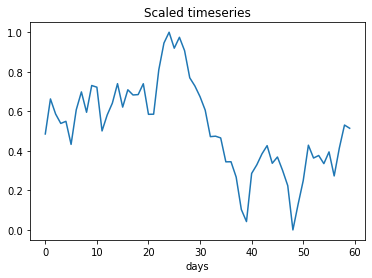

In [10]:
plt.plot(X_Scaled[0])
plt.title("Scaled timeseries");
plt.xlabel("days");

### DCT preprocessing

In [15]:
from TS_utils import DCT_lowpass_filter

lowpass_filter = DCT_lowpass_filter()
X_dct_reconstructed = lowpass_filter.fit_transform(np.array(X_Scaled))
X_dct = lowpass_filter.X_dct
n_dct = lowpass_filter.nb_coefs


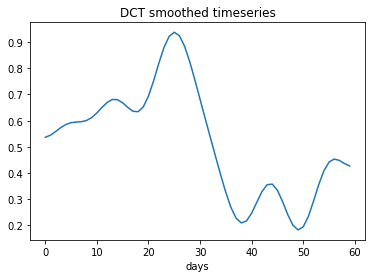

In [18]:
plt.plot(X_dct_reconstructed[0])
plt.title("DCT smoothed timeseries");
plt.xlabel("days");

### How we achieve multiscale data points

Two methods

* By picking prices every consecutive, alterate and every 2 days 

* By picking consecutive prices for 50, 100, 150 days.

Please see methods `get_multiscale_skipped_values` and `get_multiscale_consecutive_values`



In [19]:
def get_multiscale_skipped_values(df_start_end):
  days_60 = df_start_end[-60:]
  days_40 = [0 if i % 2 else x for i, x in enumerate(days_60)]
  days_20 = [0 if i % 3 else x for i, x in enumerate(days_60)]
  dictionary = {'60_days': np.array(days_60), '40_days': np.array(days_40), 
                '20_days': np.array(days_20)}
  return dictionary

def get_multiscale_consecutive_values(df_start_end):
  days_20 = df_start_end[-20:]
  days_40 = df_start_end[-40:]
  days_60 = df_start_end[-60:]
  
  days_20_all = np.append(np.zeros((40)), days_20 ,0)
  days_40_all = np.append(np.zeros((20)), days_40,0)
  
  dictionary = {'20_days': np.array(days_20_all), '40_days': np.array(days_40_all),
                    '60_days': days_60}
  return dictionary


skipped_values = []
consecutive_values = []
n = 0
for df in X_dct_reconstructed:
 
  n = n + 1
  if n%1000 == 0:
    print("{} stocksout of {} completed".format(n,len(X_dct_reconstructed)))
  
  dictionary_skipped_values = get_multiscale_skipped_values(df)
  dictionary_consecutive_values = get_multiscale_consecutive_values(df)
 
  datapoint_skipped_values = pd.DataFrame(dictionary_skipped_values).to_numpy()
  datapoint_consecutive_values = pd.DataFrame(dictionary_consecutive_values).to_numpy()


  skipped_values.append(datapoint_skipped_values)
  consecutive_values.append(datapoint_consecutive_values)


1000 stocksout of 4000 completed
2000 stocksout of 4000 completed
3000 stocksout of 4000 completed
4000 stocksout of 4000 completed


In [ ]:
np.save("/content/drive/My Drive/capstone/skipped_values_DCT.npy", skipped_values)
np.save("/content/drive/My Drive/capstone/consecutive_values_DCT.npy", consecutive_values)

## Visualization of data points

In [25]:
skipped_values[0].T

array([[0.53638319, 0.54470331, 0.55854419, 0.57349856, 0.5854285 ,
        0.59222665, 0.59469637, 0.59614569, 0.60082927, 0.61187124,
        0.62955421, 0.65075221, 0.66984966, 0.68088928, 0.68016489,
        0.66823479, 0.65048657, 0.63589057, 0.63425248, 0.65286325,
        0.69371583, 0.75230268, 0.81847103, 0.87908983, 0.92164042,
        0.93752225, 0.92398671, 0.88412965, 0.82509068, 0.75525145,
        0.6815522 , 0.60793364, 0.53540797, 0.46357031, 0.39275468,
        0.32576221, 0.26825898, 0.22749578, 0.20972834, 0.21732313,
        0.24677017, 0.28857689, 0.32935857, 0.35560953, 0.35794841,
        0.3343553 , 0.29118302, 0.24145547, 0.20090943, 0.18305165,
        0.1948866 , 0.23477049, 0.29312255, 0.35573038, 0.4084773 ,
        0.44182693, 0.45350474, 0.44848188, 0.43635228, 0.42714073],
       [0.53638319, 0.        , 0.55854419, 0.        , 0.5854285 ,
        0.        , 0.59469637, 0.        , 0.60082927, 0.        ,
        0.62955421, 0.        , 0.66984966, 0. 

In [36]:
s = skipped_values[0]
pd.DataFrame(s,columns=["60","40","20"]).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
60,0.536383,0.544703,0.558544,0.573499,0.585428,0.592227,0.594696,0.596146,0.600829,0.611871,0.629554,0.650752,0.66985,0.680889,0.680165,0.668235,0.650487,0.635891,0.634252,0.652863,0.693716,0.752303,0.818471,0.87909,0.92164,0.937522,0.923987,0.88413,0.825091,0.755251,0.681552,0.607934,0.535408,0.46357,0.392755,0.325762,0.268259,0.227496,0.209728,0.217323,0.24677,0.288577,0.329359,0.35561,0.357948,0.334355,0.291183,0.241455,0.200909,0.183052,0.194887,0.23477,0.293123,0.35573,0.408477,0.441827,0.453505,0.448482,0.436352,0.427141
40,0.536383,0.000000,0.558544,0.000000,0.585428,0.000000,0.594696,0.000000,0.600829,0.000000,0.629554,0.000000,0.66985,0.000000,0.680165,0.000000,0.650487,0.000000,0.634252,0.000000,0.693716,0.000000,0.818471,0.00000,0.92164,0.000000,0.923987,0.00000,0.825091,0.000000,0.681552,0.000000,0.535408,0.00000,0.392755,0.000000,0.268259,0.000000,0.209728,0.000000,0.24677,0.000000,0.329359,0.00000,0.357948,0.000000,0.291183,0.000000,0.200909,0.000000,0.194887,0.00000,0.293123,0.00000,0.408477,0.000000,0.453505,0.000000,0.436352,0.000000
20,0.536383,0.000000,0.000000,0.573499,0.000000,0.000000,0.594696,0.000000,0.000000,0.611871,0.000000,0.000000,0.66985,0.000000,0.000000,0.668235,0.000000,0.000000,0.634252,0.000000,0.000000,0.752303,0.000000,0.00000,0.92164,0.000000,0.000000,0.88413,0.000000,0.000000,0.681552,0.000000,0.000000,0.46357,0.000000,0.000000,0.268259,0.000000,0.000000,0.217323,0.00000,0.000000,0.329359,0.00000,0.000000,0.334355,0.000000,0.000000,0.200909,0.000000,0.000000,0.23477,0.000000,0.00000,0.408477,0.000000,0.000000,0.448482,0.000000,0.000000


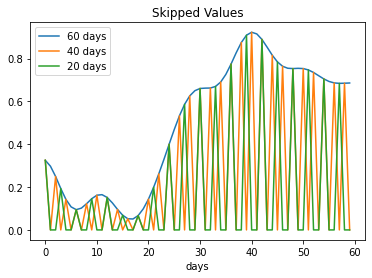

In [20]:
from matplotlib import pyplot as plt 

fig, ax = plt.subplots()
lines = ax.plot(datapoint_skipped_values)
ax.set_title("Skipped Values") 
ax.set(xlabel='days')
ax.legend(['60 days', '40 days', '20 days'])

In [ ]:
from matplotlib import pyplot as plt 

fig, ax = plt.subplots()
lines = ax.plot(datapoint_consecutive_values)
ax.set_title("Padded Values") 
ax.set(xlabel='days')
ax.legend(['20 days', '40 days', '60 days'])